<a href="https://colab.research.google.com/github/vivianrb/PrimerProyecto/blob/main/Actividad_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

Integrantes:
* Uriarte Avelar Jesús Eduardo
* Rivera Barrantes Viviana

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


### Carga de los datos

In [1]:
import cv2
import os
import numpy as np
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

In [1]:
!pip install keras-preprocessing
!sudo apt-get update
!sudo apt-get install build-essential python3-dev
!pip install --upgrade pip setuptools wheel
!pip install scikit-learn==0.24.2
!pip install tensorflow
!pip install keras
#!pip install scikit-learn==0.24
# !pip uninstall scikit-learn
# !pip install -U scikit-learn
# !pip install /path/to/scikit_learn.whl

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [34]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

#import keras_preprocessing
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Cambiar el tamaño de las figuras predeterminadas
plt.rcParams["figure.figsize"] = (20,6)

In [35]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [2]:
# Primero, bajamos los datos de entrenamiento
import tensorflow as tf # Added this line to ensure keras is accessible through tensorflow

tf.keras.utils.get_file(fname="simpsons_train.tar.gz", # Changed keras.utils to tf.keras.utils
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
tf.keras.utils.get_file(fname="simpsons_test.tar.gz", # Changed keras.utils to tf.keras.utils
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

523789527/523789527 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step
10658925/10658925 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
!sudo find / -name "simpsons*"

/root/.keras/datasets/simpsons_test.tar.gz
/root/.keras/datasets/simpsons_train.tar.gz
/root/.keras/datasets/simpsons_testset
/root/.keras/datasets/simpsons
find: ‘/proc/73/task/73/net’: Invalid argument
find: ‘/proc/73/net’: Invalid argument


In [4]:
ls /root/.keras/datasets/simpsons

abraham_grampa_simpson/    edna_krabappel/        lionel_hutz/          patty_bouvier/
agnes_skinner/             fat_tony/              lisa_simpson/         principal_skinner/
apu_nahasapeemapetilon/    gil/                   maggie_simpson/       professor_john_frink/
barney_gumble/             groundskeeper_willie/  marge_simpson/        rainier_wolfcastle/
bart_simpson/              hans_moleman/          martin_prince/        ralph_wiggum/
bumblebee_man/             helen_lovejoy/         mayor_quimby/         selma_bouvier/
carl_carlson/              homer_simpson/         milhouse_van_houten/  sideshow_bob/
charles_montgomery_burns/  jasper_beardly/        miss_hoover/          sideshow_mel/
chief_wiggum/              jimbo_jones/           moe_szyslak/          snake_jailbird/
cletus_spuckler/           kent_brockman/         ned_flanders/         troy_mcclure/
comic_book_guy/            krusty_the_clown/      nelson_muntz/         waylon_smithers/
disco_stu/                 l

In [5]:
ls /root/.keras/datasets/simpsons_testset

abraham_grampa_simpson_0.jpg     edna_krabappel_41.jpg    mayor_quimby_23.jpg
abraham_grampa_simpson_10.jpg    edna_krabappel_42.jpg    mayor_quimby_24.jpg
abraham_grampa_simpson_11.jpg    edna_krabappel_43.jpg    mayor_quimby_25.jpg
abraham_grampa_simpson_12.jpg    edna_krabappel_44.jpg    mayor_quimby_26.jpg
abraham_grampa_simpson_13.jpg    edna_krabappel_45.jpg    mayor_quimby_27.jpg
abraham_grampa_simpson_14.jpg    edna_krabappel_46.jpg    mayor_quimby_28.jpg
abraham_grampa_simpson_15.jpg    edna_krabappel_47.jpg    mayor_quimby_29.jpg
abraham_grampa_simpson_16.jpg    edna_krabappel_48.jpg    mayor_quimby_2.jpg
abraham_grampa_simpson_17.jpg    edna_krabappel_49.jpg    mayor_quimby_30.jpg
abraham_grampa_simpson_18.jpg    edna_krabappel_4.jpg     mayor_quimby_31.jpg
abraham_grampa_simpson_19.jpg    edna_krabappel_5.jpg     mayor_quimby_32.jpg
abraham_grampa_simpson_1.jpg     edna_krabappel_6.jpg     mayor_quimby_33.jpg
abraham_grampa_simpson_20.jpg    edna_krabappel_7.jpg     mayor_q

In [6]:
# Descomprimimos el archivo en tmp para visualizar
!sudo mkdir -p /tmp/simpsons
# !sudo tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [7]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [8]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [9]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [10]:
import cv2
import os # Added import statement for the 'os' module
import numpy as np
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [11]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

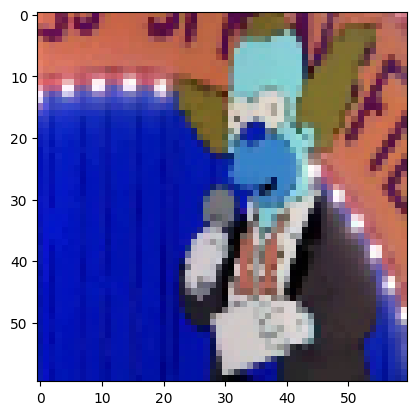

In [12]:
plt.imshow(X_t[2])

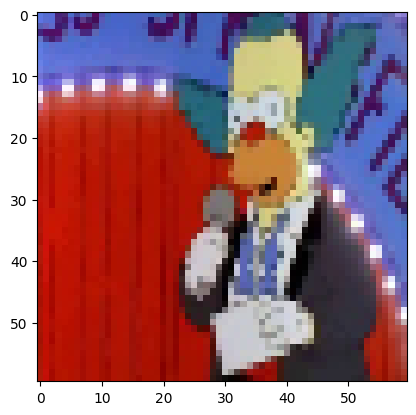

In [13]:
plt.imshow(np.flip(X_t[2], axis=-1) )

In [14]:
!pip install tensorflow keras scikit-learn matplotlib numpy

In [16]:
import tensorflow as tf

# Cargar el dataset desde el directorio de imágenes
directory = "/root/.keras/datasets/simpsons/"  # Ajusta la ruta si es necesario

In [17]:
# Cargar datos de entrenamiento
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",  # Etiquetas inferidas de los nombres de las carpetas
    label_mode="int",   # Representación de etiquetas como enteros
    batch_size=32,
    image_size=(256, 256),  # Redimensionar las imágenes a 256x256 píxeles
    shuffle=True,  # Mezclar las imágenes
    validation_split=0.2,  # 20% de los datos para validación
    subset="training",  # Usar solo el conjunto de entrenamiento
    seed=123,  # Semilla para reproducibilidad
)

Found 20933 files belonging to 47 classes.
Using 16747 files for training.


In [18]:
# Cargar datos de validación
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    validation_split=0.2,
    subset="validation",  # Usar solo el conjunto de validación
    seed=123,
)

Found 20933 files belonging to 47 classes.
Using 4186 files for validation.


In [19]:
# Normalizar las imágenes (valores de 0 a 1)
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
validation_dataset = validation_dataset.map(lambda x, y: (x / 255.0, y))

In [20]:
# Modelo CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [21]:
# Construcción del modelo CNN

# Cargar el conjunto de datos de entrenamiento
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/root/.keras/datasets/simpsons/',
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=True
)

# Clases
class_names = train_dataset.class_names

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_dataset.class_names), activation='softmax')  # Una salida por clase
])

Found 20933 files belonging to 47 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Compilación del modelo
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',  # Usamos sparse_categorical_crossentropy para clasificación múltiple
              metrics=['accuracy'])

In [23]:
# Entrenamiento del modelo
from tensorflow.keras.callbacks import EarlyStopping

# Entrenar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=[early_stopping],
)


Epoch 1/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 4182s 6s/step - accuracy: 0.1160 - loss: 24.4244 - val_accuracy: 0.1061 - val_loss: 3.1971
Epoch 2/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 4221s 6s/step - accuracy: 0.2404 - loss: 2.7021 - val_accuracy: 0.1075 - val_loss: 3.2352
Epoch 3/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 4181s 6s/step - accuracy: 0.4333 - loss: 1.9931 - val_accuracy: 0.1116 - val_loss: 3.7633
Epoch 4/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 4104s 6s/step - accuracy: 0.5997 - loss: 1.3867 - val_accuracy: 0.1061 - val_loss: 4.8112


In [ ]:
# Evaluación y métricas de rendimiento

# Evaluar el modelo en el conjunto de validación
test_loss, test_acc = model.evaluate(validation_dataset)
print(f"Test accuracy: {test_acc}")

 41/131 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - accuracy: 0.1042 - loss: 3.2255

In [28]:
# Generar un reporte de clasificación (precision, recall, f1-score)
from sklearn.metrics import classification_report
import numpy as np

# Obtener las predicciones
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_pred = np.argmax(model.predict(validation_dataset), axis=1)

# Obtener las etiquetas únicas de los datos de validación
unique_labels = np.unique(y_true)

# Filtrar los nombres de las clases para que coincidan con las etiquetas únicas
target_names = [class_names[i] for i in unique_labels]

# Reporte de clasificación
report = classification_report(y_true, y_pred, target_names=target_names, zero_division=0)  # Usamos target_names filtrados
print(report)

131/131 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.00      0.00      0.00       160
           agnes_skinner       0.00      0.00      0.00        10
  apu_nahasapeemapetilon       0.00      0.00      0.00       121
           barney_gumble       0.00      0.00      0.00        15
            bart_simpson       0.00      0.00      0.00       256
            carl_carlson       0.00      0.00      0.00        23
charles_montgomery_burns       0.07      0.28      0.12       252
            chief_wiggum       0.00      0.00      0.00       199
         cletus_spuckler       0.00      0.00      0.00        15
          comic_book_guy       0.00      0.00      0.00        80
          edna_krabappel       0.00      0.00      0.00        89
                fat_tony       0.00      0.00      0.00         6
                     gil       0.00      0.00      0.00         6
    groundskeeper_willie       0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


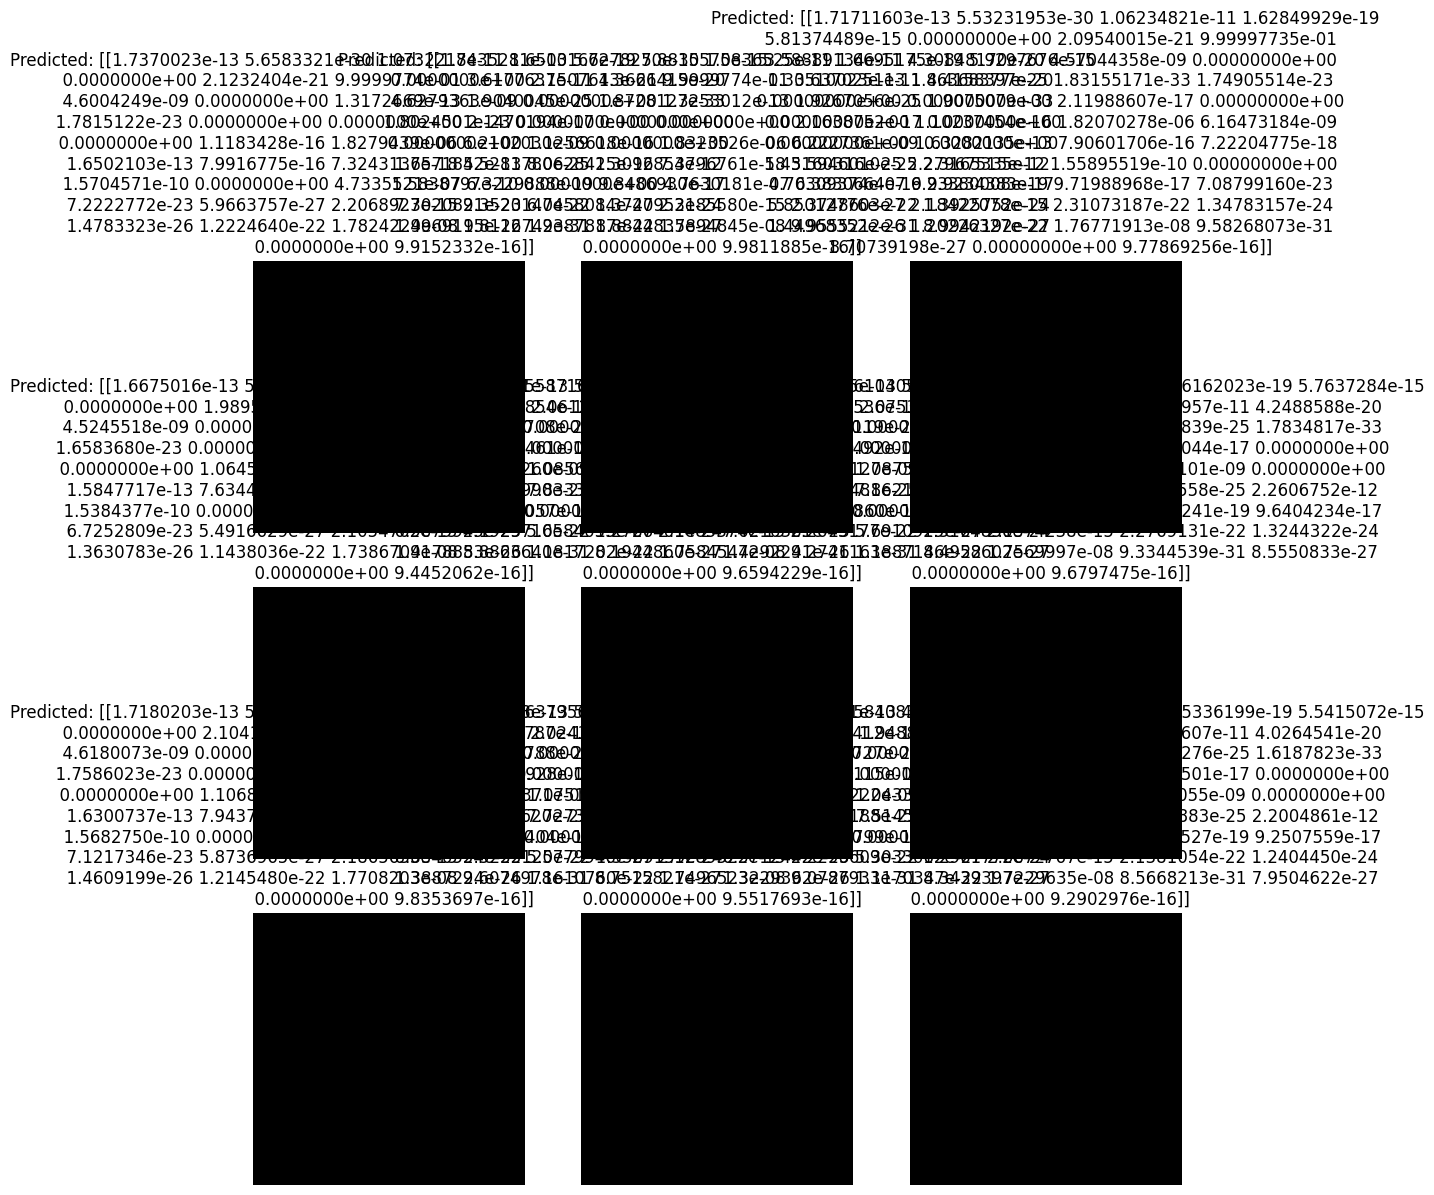

In [56]:
# Análisis de errores visuales
import matplotlib.pyplot as plt

# Visualiza algunas imágenes incorrectamente clasificadas
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for i in range(9):
    ax = axes[i]
    # Utiliza as_numpy_iterator() y __next__() para obtener el siguiente elemento
    img, label = next(iter(validation_dataset.unbatch().take(i + 1).as_numpy_iterator()))
    ax.imshow(img)
    # Cambie la forma de la imagen para agregar una dimensión por lotes
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    ax.set_title(f"Predicted: {model.predict(img)}")
    ax.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


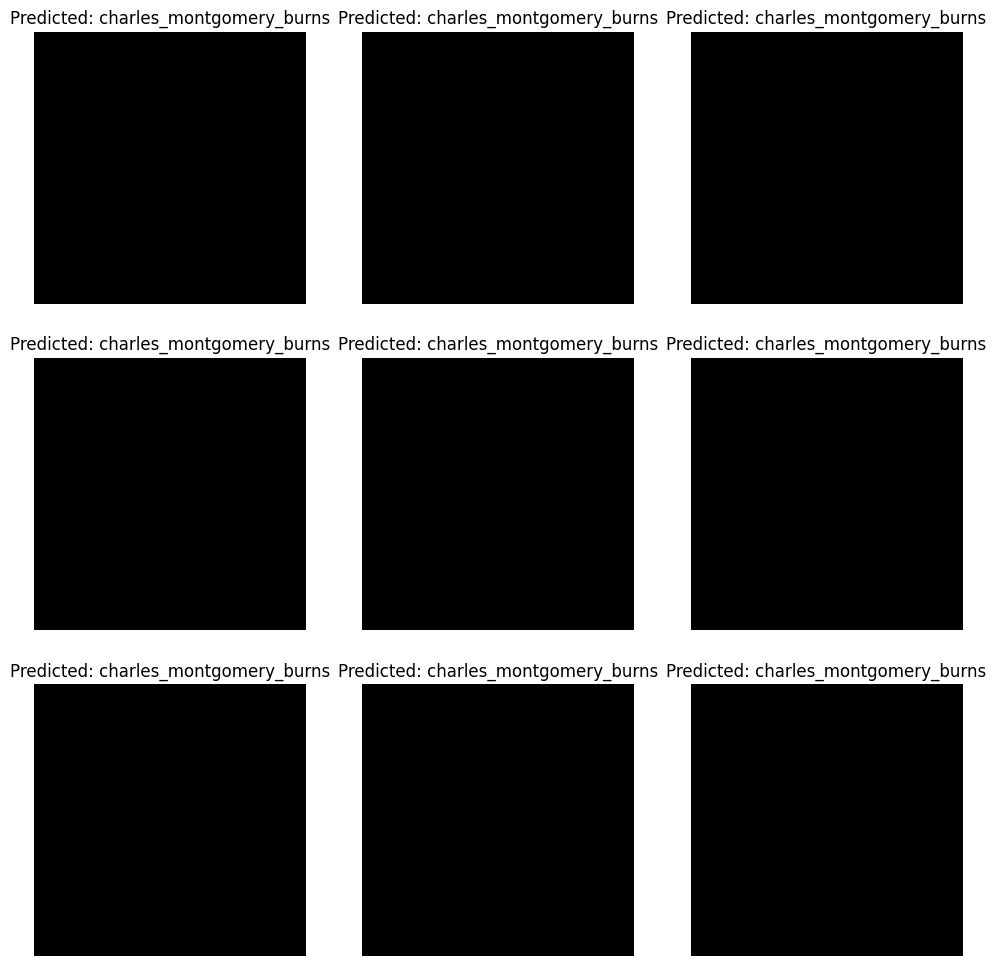

In [57]:
# Análisis de errores visuales
import matplotlib.pyplot as plt

# Visualizar algunas imágenes incorrectamente clasificadas
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for i in range(9):
    ax = axes[i]
    # Utiliza as_numpy_iterator() y __next__() para obtener el siguiente elemento
    img, label = next(iter(validation_dataset.unbatch().take(i + 1).as_numpy_iterator()))
    ax.imshow(img)

    # Cambia la forma de la imagen para agregar una dimensión por lotes
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

    # En lugar de usar get_iterator(), acceda directamente al elemento usando next(iter(...))
    # img, label = validation_dataset.unbatch().take(i + 1).get_iterator().next() # This line caused the error
    # img, label = next(iter(validation_dataset.unbatch().take(i + 1).as_numpy_iterator()))  # This line should work now

    # Predice usando la imagen reformada con dimensión de lote
    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction)  # Obtener el índice de la clase prevista.
    predicted_class_name = class_names[predicted_class_index]  # Obtener el nombre de la clase prevista


    ax.set_title(f"Predicted: {predicted_class_name}") # Mostrar el nombre de clase previsto
    ax.axis('off')

plt.show()

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos para ser analizados en vuestro informe:

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

** Nota(Borrarse al terminar la actividad): Utilizar la carga de datos superior y datos relacionas en caso de requerirse y realizar un modelo basado en el proporcionado pero mejorado donde tenga modificaciones que mejoren el rendimeinto del modelo, realizar un modelo con uso de transfer learning, realizar un modelo desde cero de propuesta (pero puede utilizar la carga de datos y elementos del preprocesamiento en adelante)(todos los modelos deben de usar los elementos del preprocesamiento en adelante),realizar un modelo basado en el modelo desde cero con cambios/adiciones/mejoras(mas neuronas, mas capas, una capa fully connected adicional, etc) **

### Preprocesamiento del conjunto de entrenamiento

In [42]:
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [58]:
# Descargar y Descomprimir los Datos

# keras.utils.get_file(fname="simpsons_train.tar.gz",
# origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimir los archivos
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Cargar las imágenes desde los directorios correspondientes
train_dir = '/root/.keras/datasets/simpsons'  # Changed from 'simpsons_train' to 'simpsons'
valid_dir = '/root/.keras/datasets/simpsons_testset' # Changed from 'simpsons_test' to 'simpsons_testset'

# Carga de Imágenes usando ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# NOTA: train_generator y validation_generator se emplean en los modelos de dropout, normalización y el primer modelo

# Normalización

# Preprocesamiento de datos para el conjunto de validación (sin aumento de datos)
train_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Preprocesamiento de datos para el conjunto de test (sin aumento de datos)
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

### DataAugmentation

In [59]:
# Cargar imágenes desde los directorios de entrenamiento, validación y test

# --------------------
# Flujo de imagenes de entrenamiento en batches de 20 usando el "train_datagen generator"
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150)) # Redimensionar las imágenes

# --------------------
# Flujo de imagenes de entrenamiento en batches de 20 usando el "test_datagen generator"
# --------------------
validation_generator =  test_datagen.flow_from_directory(valid_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 20933 images belonging to 47 classes.
Found 0 images belonging to 0 classes.


### Transformacion

In [ ]:
# Definir las transformaciones para el conjunto de validación (solo normalización, sin aumento de datos)
# validation_datagen = ImageDataGenerator(rescale=1./255)  # Solo normalización de los valores de los píxeles

# Ruta a los directorios de entrenamiento y validación
# train_dir = '/root/.keras/datasets/simpsons_train'
# validation_dir = '/root/.keras/datasets/simpsons_test'

### Normalizacion

In [60]:
# Ver algunas imágenes del generador de entrenamiento
x_batch, y_batch = next(train_generator)  # Obtén un batch de imágenes

print("Primeros valores de una imagen después de la normalización (del batch de entrenamiento):")
print(x_batch[0, 10, 8:15])  # Imprime los valores de los píxeles en una sección de la primera imagen

# También puedes revisar el rango de los valores de la imagen
print("Rango de valores de los píxeles (deberían estar entre 0 y 1):")
print(x_batch.min(), x_batch.max())  # Verifica que los valores estén entre 0 y 1


Primeros valores de una imagen después de la normalización (del batch de entrenamiento):
[[0.62352943 0.60784316 0.5019608 ]
 [0.62352943 0.60784316 0.5019608 ]
 [0.62352943 0.60784316 0.5019608 ]
 [0.62352943 0.60784316 0.5019608 ]
 [0.6039216  0.5882353  0.48235297]
 [0.6039216  0.5882353  0.48235297]
 [0.6039216  0.5882353  0.48235297]]
Rango de valores de los píxeles (deberían estar entre 0 y 1):
0.0 1.0


### Desarrollo y entrenamiento de los modelos

#### Modelo A: * Nombre del modelo(ejemplo RNN)(Implementar aqui el modelo basado en el original de la actividad pero mejorado) *

Modelo desarrollado por Rivera Barrantes Viviana

##### Desarrollo del modelo

In [67]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback para EarlyStopping (detiene el entrenamiento si la validación no mejora)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Callback para guardar el mejor modelo durante el entrenamiento
checkpoint = ModelCheckpoint('simpsons_cnn_model.keras', # Changed .h5 to .keras
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

# Adjust the input shape to match your image size
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)), # Changed input shape to (150, 150, 3)
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax') # Use len(train_generator.class_indices) for num_classes
])

# Compilación del modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##### Entrenamiento del modelo

In [ ]:
# Entrenamiento del modelo

# Fit the model with the updated generators
history = model.fit(
    train_generator, # Generador de entrenamiento
    steps_per_epoch=train_generator.samples // train_generator.batch_size,# Número de pasos por época
    epochs=50,# Número de épocas
    validation_data=validation_generator,# Generador de validación
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Pasos de validación
    callbacks=[early_stopping, checkpoint] # Llamadas a los callbacks
)

Epoch 1/50
 809/1046 ━━━━━━━━━━━━━━━━━━━━ 5:18 1s/step - accuracy: 0.6908 - loss: 1.1395

##### Analisis del modelo

Requiere de uso de graficas, matrices de funcision y metricas de evaluacion

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)

# Mostrar los resultados
print(f"Loss en el conjunto de pruebas: {test_loss:.4f}")
print(f"Accuracy en el conjunto de pruebas: {test_acc:.4f}")

#### Modelo B: * Nombre del modelo(ejemplo RNN) (Implementar aqui el modelo propuesta que utiliza transfer-learning) *

Modelo desarrollado por Uriarte Avelar Jesús Eduardo

##### Desarrollo del modelo

##### Entrenamiento del modelo

##### Analisis del modelo

Requiere de uso de graficas, matrices de funcision y metricas de evaluacion

#### Modelo C: * Nombre del modelo(ejemplo RNN) (Implementar aqui el modelo propuesta que desde cero) *

Modelo desarrollado por  Rivera Barrantes Viviana

##### Desarrollo del modelo

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model_b = Sequential()

# Primera capa convolucional
model_b.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model_b.add(BatchNormalization())  # Normalización para estabilizar el entrenamiento
model_b.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional
model_b.add(Conv2D(64, (3, 3), activation='relu'))
model_b.add(BatchNormalization())
model_b.add(MaxPooling2D(pool_size=(2, 2)))

# Tercera capa convolucional
model_b.add(Conv2D(128, (3, 3), activation='relu'))
model_b.add(BatchNormalization())
model_b.add(MaxPooling2D(pool_size=(2, 2)))

# Cuarta capa convolucional
model_b.add(Conv2D(256, (3, 3), activation='relu'))
model_b.add(BatchNormalization())
model_b.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanamiento de las capas convolucionales para pasar a la capa densa
model_b.add(Flatten())

# Capa completamente conectada (Fully Connected)
model_b.add(Dense(512, activation='relu'))  # Más neuronas en la capa densa
model_b.add(Dropout(0.5))  # Regularización Dropout

# Capa de salida
model_b.add(Dense(num_classes, activation='softmax'))  # Número de clases de personajes

# Compilamos el modelo
model_b.compile(optimizer=Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Resumen del modelo
model_b.summary()


##### Entrenamiento del modelo

In [ ]:
# Entrenamiento del Modelo B (Desde Cero)
history_b = model_b.fit(
    train_generator,  # Generador de datos para entrenamiento
    epochs=50,  # Número de épocas
    validation_data=valid_generator,  # Generador de datos para validación
    validation_steps=10,  # Número de pasos para la validación
    steps_per_epoch=200,  # Número de pasos por época en el conjunto de entrenamiento
    callbacks=[early_stop]  # Callback para detener el entrenamiento si no mejora
)


##### Analisis del modelo

Requiere de uso de graficas, matrices de funcision y metricas de evaluacion

In [ ]:
# Graficar precisión del entrenamiento y la validación
plt.figure(figsize=(12, 6))
plt.plot(history_a.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(history_a.history['val_accuracy'], label='Precisión Validación')
plt.title('Precisión durante el entrenamiento (Modelo A)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model_a.evaluate(test_generator, steps=10)
print(f'Pérdida en Test: {test_loss}')
print(f'Precisión en Test: {test_acc}')


#### Modelo D: * Nombre del modelo(ejemplo RNN) (Implementar aqui el modelo propuesta basado en el desde cero pero mejorado) *

Modelo desarrollado por Uriarte Avelar Jesús Eduardo

##### Desarrollo del modelo

##### Entrenamiento del modelo

##### Analisis del modelo

Requiere de uso de graficas, matrices de funcision y metricas de evaluacion

### Conclusiones

**Conclusion de Viviana:**

**Conclusion de Eduardo:**

**Conclusion de General:**

### Referencias APA

  * Referencia 1